In [ ]:
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

PROJECT_ROOT = Path("..").resolve()


DATA_DIR = PROJECT_ROOT / "data" / "Converted Images"


OUT_DIR  = PROJECT_ROOT / "outputs"
PREP_DIR = OUT_DIR / "preprocessed_index" 
PREP_DIR.mkdir(parents=True, exist_ok=True)
INDEX_CSV = OUT_DIR / "preprocessed_index.csv"

EXTS = {".jpg", ".jpeg", ".png", ".bmp"}


RESIZE_MODE = "fixed300"
FIXED_SIZE = (300, 300)   
TARGET_WIDTH = 480        # ini jaga"

GAUSS_KSIZE = (5, 5)
GAUSS_SIGMA = 0
GAMMA = 1.2  



Scan Dataset & Binary Labeling

In [ ]:
def scan_dataset(root: Path):
    rows = []
    for cls_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        cls = cls_dir.name
        for fp in cls_dir.rglob("*"):
            if fp.is_file() and fp.suffix.lower() in EXTS:
                # Healthy = 0, else/diseased = 1
                y = 0 if cls.lower() == "healthy" else 1
                rows.append({
                    "orig_path": str(fp),
                    "class": cls,
                    "Output": y,
                })
    return pd.DataFrame(rows)

df = scan_dataset(DATA_DIR)
print("DATA_DIR:", DATA_DIR)
print("Total images:", len(df))
df.head()


DATA_DIR: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\data\Converted Images
Total images: 724


orig_path        class  Output
0  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1
1  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1
2  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1
3  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1
4  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1

In [3]:
df

orig_path        class  Output
0    E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1
1    E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1
2    E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1
3    E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1
4    E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1
..                                                 ...          ...     ...
719  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Stem_Canker       1
720  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Stem_Canker       1
721  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Stem_Canker       1
722  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Stem_Canker       1
723  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Stem_Canker       1

[724 rows x 3 columns]

Resize + Preprocessing function (terapin seperti di segmentation_test)

In [ ]:
def resize_bilinear(bgr: np.ndarray, size_wh=FIXED_SIZE) -> np.ndarray:
    return cv2.resize(bgr, size_wh, interpolation=cv2.INTER_LINEAR)

def gaussian_denoise(bgr: np.ndarray, ksize=GAUSS_KSIZE, sigma=GAUSS_SIGMA) -> np.ndarray:
    return cv2.GaussianBlur(bgr, ksize, sigma)

def gamma_correction_uint8(img_uint8: np.ndarray, gamma: float = GAMMA) -> np.ndarray:
    if gamma <= 0:
        return img_uint8
    inv = 1.0 / gamma
    table = (np.arange(256) / 255.0) ** inv
    table = np.clip(table * 255.0, 0, 255).astype(np.uint8)
    return cv2.LUT(img_uint8, table)

def hist_equalize_gray(gray_uint8: np.ndarray) -> np.ndarray:
    return cv2.equalizeHist(gray_uint8)

def preprocess_paper(bgr: np.ndarray) -> np.ndarray:
    bgr = resize_bilinear(bgr, FIXED_SIZE)

    bgr = gaussian_denoise(bgr, GAUSS_KSIZE, GAUSS_SIGMA)

    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    gray = gamma_correction_uint8(gray, GAMMA)

    gray_eq = hist_equalize_gray(gray)
    return gray_eq


Preprocessing & Save

In [5]:
def out_path_for(in_path: str, cls: str) -> Path:
    in_p = Path(in_path)
    out_dir = PREP_DIR / cls
    out_dir.mkdir(parents=True, exist_ok=True)
    return out_dir / in_p.name

rows = []
failed = 0

for r in tqdm(df.to_dict("records"), desc="Preprocessing (paper)"):
    in_path = r["orig_path"]
    cls = r["class"]
    y = int(r["Output"])

    bgr = cv2.imread(in_path)
    if bgr is None:
        failed += 1
        continue

    gray_eq = preprocess_paper(bgr)

    out_fp = out_path_for(in_path, cls)
    ok = cv2.imwrite(str(out_fp), gray_eq)
    if not ok:
        failed += 1
        continue

    rows.append({
        "orig_path": in_path,
        "prep_path": str(out_fp),
        "class": cls,
        "Output": y,
        "width": FIXED_SIZE[0],
        "height": FIXED_SIZE[1],
        "resize_mode": "fixed300_bilinear",
        "gaussian": f"{GAUSS_KSIZE}_sigma{GAUSS_SIGMA}",
        "gamma": GAMMA,
        "equalization": "hist_eq",
    })

df_prep = pd.DataFrame(rows)
df_prep.to_csv(INDEX_CSV, index=False)

print("Saved preprocessed images to:", PREP_DIR)
print("Index CSV:", INDEX_CSV)


print("Saved preprocessed images to:", PREP_DIR)
print("Index CSV:", PREP_DIR)
print("df_prep shape:", df_prep.shape, "| failed:", failed)
df_prep.head()


Preprocessing (paper): 100%|██████████| 724/724 [00:01<00:00, 404.26it/s]

Saved preprocessed images to: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\preprocessed_index
Index CSV: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\preprocessed_index.csv
Saved preprocessed images to: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\preprocessed_index
Index CSV: E:\Kuliah\Pengenalan Pola\addressing_agricultural_challenges\outputs\preprocessed_index
df_prep shape: (724, 10) | failed: 0


orig_path  \
0  E:\Kuliah\Pengenalan Pola\addressing_agricultu...   
1  E:\Kuliah\Pengenalan Pola\addressing_agricultu...   
2  E:\Kuliah\Pengenalan Pola\addressing_agricultu...   
3  E:\Kuliah\Pengenalan Pola\addressing_agricultu...   
4  E:\Kuliah\Pengenalan Pola\addressing_agricultu...   

                                           prep_path        class  Output  \
0  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1   
1  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1   
2  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1   
3  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1   
4  E:\Kuliah\Pengenalan Pola\addressing_agricultu...  Anthracnose       1   

   width  height        resize_mode       gaussian  gamma equalization  
0    300     300  fixed300_bilinear  (5, 5)_sigma0    1.2      hist_eq  
1    300     300  fixed300_bilinear  (5, 5)_sigma0    1.2      hist_eq  
2    300     300  fixed300_bilinear  (5, 5)_sigma0    1.2      hist_eq  
3    300     300  fixed300_bilinear  (5, 5)_sigma0    1.2      hist_eq  
4    300     300  fixed300_bilinear  (5, 5)_sigma0    1.2      hist_eq

Sampling Before & After

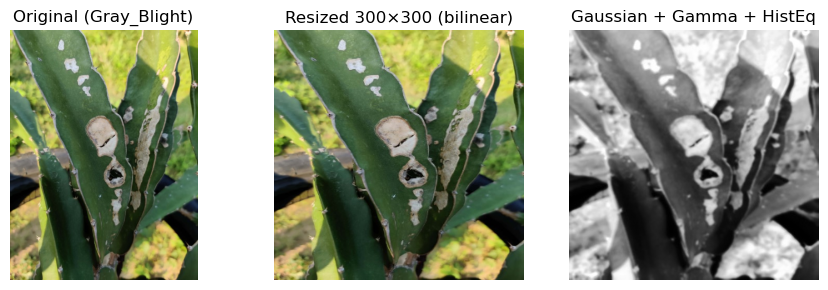

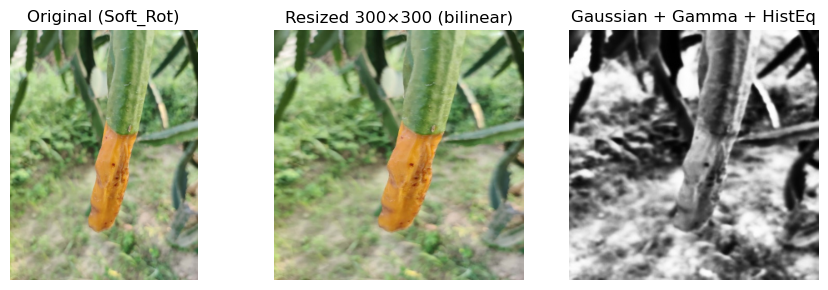

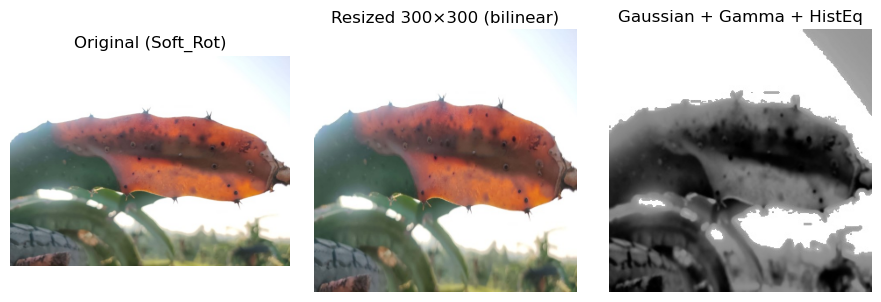

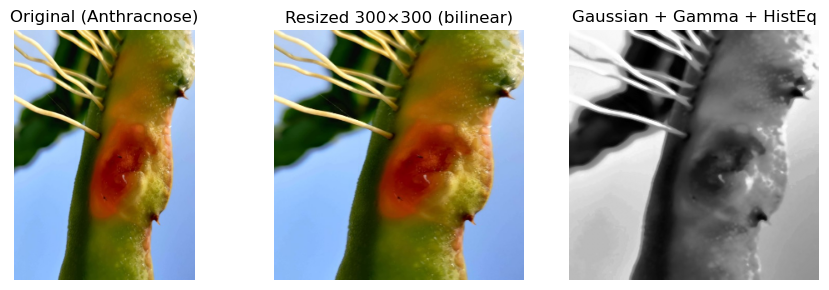

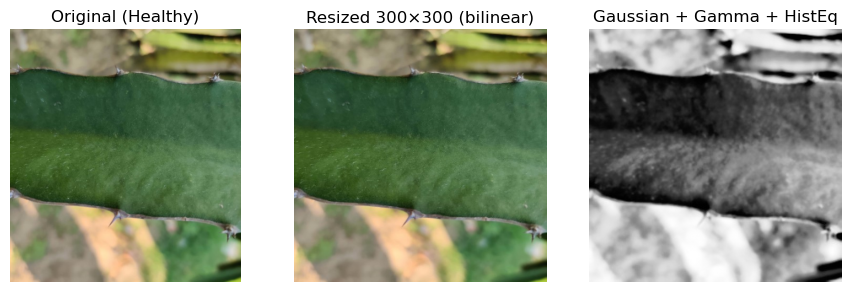

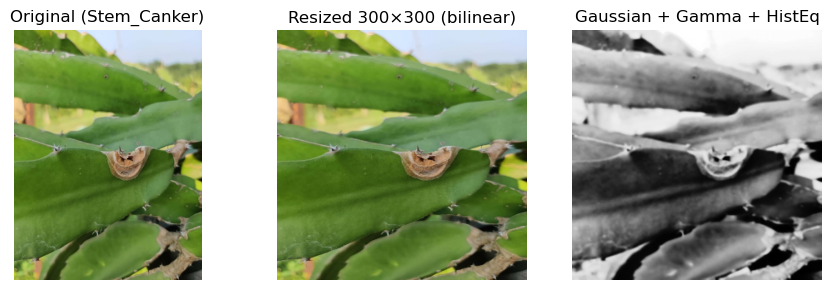

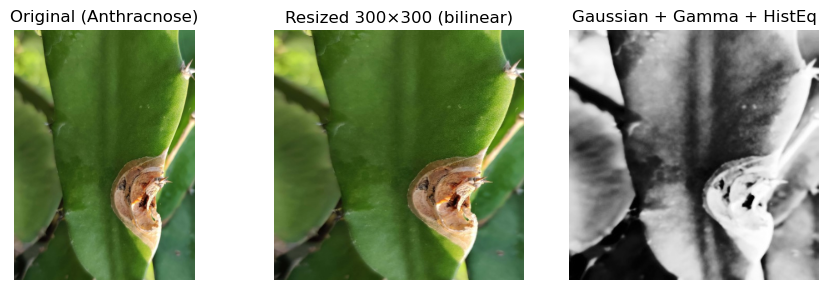

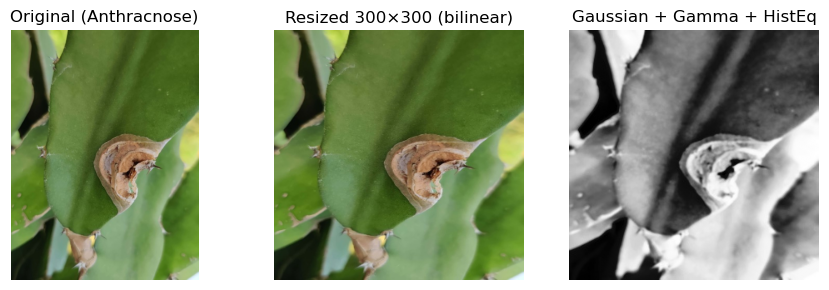

In [6]:
import random
import matplotlib.pyplot as plt

def bgr_to_rgb(bgr):
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

sample_n = 8
sample_df = df_prep.sample(min(sample_n, len(df_prep)), random_state=42)

for i, r in enumerate(sample_df.to_dict("records"), start=1):
    orig = cv2.imread(r["orig_path"])
    prep = cv2.imread(r["prep_path"], cv2.IMREAD_GRAYSCALE)

    orig_resized = cv2.resize(orig, FIXED_SIZE, interpolation=cv2.INTER_LINEAR)

    fig = plt.figure(figsize=(9, 3))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)

    ax1.imshow(bgr_to_rgb(orig))
    ax1.set_title(f"Original ({r['class']})")
    ax1.axis("off")

    ax2.imshow(bgr_to_rgb(orig_resized))
    ax2.set_title("Resized 300×300 (bilinear)")
    ax2.axis("off")

    ax3.imshow(prep, cmap="gray")
    ax3.set_title("Gaussian + Gamma + HistEq")
    ax3.axis("off")

    plt.tight_layout()
    plt.show()


## v2

def resize_fixed(gray, size_wh=(256,256)):
    return cv2.resize(gray, size_wh, interpolation=cv2.INTER_AREA)

def resize_keep_aspect_width(gray, target_width=480, allow_upscale=True):
    h, w = gray.shape[:2]
    if w == target_width:
        return gray
    if (w < target_width) and (not allow_upscale):
        return gray
    scale = target_width / float(w)
    new_h = int(round(h * scale))
    return cv2.resize(gray, (target_width, new_h), interpolation=cv2.INTER_AREA)

def apply_sharpening(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def preprocess_gray_clahe(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    if RESIZE_MODE == "fixed256":
        gray = resize_fixed(gray, FIXED_SIZE)
    elif RESIZE_MODE == "width480":
        gray = resize_keep_aspect_width(gray, TARGET_WIDTH, allow_upscale=True)
    else:
        raise ValueError("RESIZE_MODE harus 'fixed256' atau 'width480'")

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_TILE)
    enhanced = clahe.apply(blurred)

    out = apply_sharpening(enhanced)

    return out

def out_path_for(input_path: str, cls: str) -> Path:
    fp = Path(input_path)
    cls_dir = PREP_DIR / cls
    cls_dir.mkdir(parents=True, exist_ok=True)
    return cls_dir / (fp.stem + ".png")

rows = []
failed = 0

for r in tqdm(df.to_dict("records"), desc="Preprocessing"):
    in_path = r["path"]
    cls = r["class"]
    y = int(r["Output"])

    bgr = cv2.imread(in_path)
    if bgr is None:
        failed += 1
        continue

    gray_clahe = preprocess_gray_clahe(bgr)

    out_fp = out_path_for(in_path, cls)
    ok = cv2.imwrite(str(out_fp), gray_clahe)
    if not ok:
        failed += 1
        continue

    h, w = gray_clahe.shape[:2]
    rows.append({
        "orig_path": in_path,
        "prep_path": str(out_fp),
        "class": cls,
        "Output": y,
        "width": w,
        "height": h,
        "resize_mode": RESIZE_MODE
    })

df_prep = pd.DataFrame(rows)
PREP_DIR = OUT_DIR / "preprocessed_clahe_index.csv"
df_prep.to_csv(PREP_DIR, index=False)

print("Saved:", PREP_DIR)
print("Processed:", len(df_prep), "| Failed:", failed)
df_prep.head()

## v3

Canny

def resize_fixed(gray, size_wh=(256,256)):
    return cv2.resize(gray, size_wh, interpolation=cv2.INTER_AREA)

def resize_keep_aspect_width(gray, target_width=480, allow_upscale=True):
    h, w = gray.shape[:2]
    if w == target_width:
        return gray
    if (w < target_width) and (not allow_upscale):
        return gray
    scale = target_width / float(w)
    new_h = int(round(h * scale))
    return cv2.resize(gray, (target_width, new_h), interpolation=cv2.INTER_AREA)

def preprocess_gray_clahe(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    if RESIZE_MODE == "fixed256":
        gray = resize_fixed(gray, FIXED_SIZE)
    elif RESIZE_MODE == "width480":
        gray = resize_keep_aspect_width(gray, TARGET_WIDTH, allow_upscale=True)
    else:
        raise ValueError("RESIZE_MODE harus 'fixed256' atau 'width480'")

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 100, 200)
    
    return edges

HSV Saturation (S-Channel)


def resize_fixed(gray, size_wh=(256,256)):
    return cv2.resize(gray, size_wh, interpolation=cv2.INTER_AREA)

def resize_keep_aspect_width(gray, target_width=480, allow_upscale=True):
    h, w = gray.shape[:2]
    if w == target_width:
        return gray
    if (w < target_width) and (not allow_upscale):
        return gray
    scale = target_width / float(w)
    new_h = int(round(h * scale))
    return cv2.resize(gray, (target_width, new_h), interpolation=cv2.INTER_AREA)

def preprocess_gray_clahe(bgr):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    s_channel = hsv[:, :, 1]

    if RESIZE_MODE == "fixed256":
        gray = resize_fixed(s_channel, FIXED_SIZE)
    elif RESIZE_MODE == "width480":
        gray = resize_keep_aspect_width(s_channel, TARGET_WIDTH, allow_upscale=True)
    else:
        raise ValueError("RESIZE_MODE harus 'fixed256' atau 'width480'")

    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_TILE)
    out = clahe.apply(gray)

    return out

Morphological Opening

def resize_fixed(gray, size_wh=(256,256)):
    return cv2.resize(gray, size_wh, interpolation=cv2.INTER_AREA)

def resize_keep_aspect_width(gray, target_width=480, allow_upscale=True):
    h, w = gray.shape[:2]
    if w == target_width:
        return gray
    if (w < target_width) and (not allow_upscale):
        return gray
    scale = target_width / float(w)
    new_h = int(round(h * scale))
    return cv2.resize(gray, (target_width, new_h), interpolation=cv2.INTER_AREA)

def preprocess_gray_clahe(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    if RESIZE_MODE == "fixed256":
        gray = resize_fixed(gray, FIXED_SIZE)
    elif RESIZE_MODE == "width480":
        gray = resize_keep_aspect_width(gray, TARGET_WIDTH, allow_upscale=True)
    else:
        raise ValueError("RESIZE_MODE harus 'fixed256' atau 'width480'")

    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_TILE)
    enhanced = clahe.apply(gray)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    out = cv2.morphologyEx(enhanced, cv2.MORPH_OPEN, kernel)

    return out


def out_path_for(input_path: str, cls: str) -> Path:
    fp = Path(input_path)
    cls_dir = PREP_DIR / cls
    cls_dir.mkdir(parents=True, exist_ok=True)
    return cls_dir / (fp.stem + ".png")

rows = []
failed = 0

for r in tqdm(df.to_dict("records"), desc="Preprocessing"):
    in_path = r["path"]
    cls = r["class"]
    y = int(r["Output"])

    bgr = cv2.imread(in_path)
    if bgr is None:
        failed += 1
        continue
    processed_img = preprocess_gray_clahe(bgr) 

    out_fp = out_path_for(in_path, cls)
    ok = cv2.imwrite(str(out_fp), processed_img)
    if not ok:
        failed += 1
        continue

    if len(processed_img.shape) == 2:
        h, w = processed_img.shape
    else:
        h, w = processed_img.shape[:2]
        
    rows.append({
        "orig_path": in_path,
        "prep_path": str(out_fp),
        "class": cls,
        "Output": y,
        "width": w,
        "height": h,
        "resize_mode": RESIZE_MODE
    })

df_prep = pd.DataFrame(rows)
PREP_DIR = OUT_DIR / "preprocessed_clahe_index.csv"
df_prep.to_csv(PREP_DIR, index=False)

print("Saved Index:", PREP_DIR)
print("Processed:", len(df_prep), "| Failed:", failed)
display(df_prep.head())